In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
import scipy.io as sio
from example_reactiondiffusion import get_rd_data
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

//anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_path = os.getcwd() + '/'
save_name = 'model2'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

In [3]:
# data = sio.loadmat('../../rd_solver/reaction_diffusion_test.mat')
# n_samples = data['t'].size
# data['uf'] += 1e-6*np.random.normal(size=data['uf'].shape)
# data['duf'] += 1e-6*np.random.normal(size=data['duf'].shape)
# test_data = {'t': data['t'],
#              'x': data['uf'].reshape((params['input_dim'],-1)).T,
#              'dx': data['duf'].reshape((params['input_dim'],-1)).T}
_,_,test_data = get_rd_data()

## Single trajectory plots

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from ./models_rd/model2


In [5]:
z_sim = sindy_simulate(test_set_results['z'][0], test_data['t'][:,0],
                       params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])

(-49.95, 1048.95, -0.9179217665500203, 0.9179202615574544)

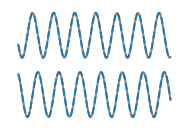

In [6]:
plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][:,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(test_set_results['z'][:,1], color='#888888', linewidth=2)
plt.plot(z_sim[:,1], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

([], <a list of 0 Text yticklabel objects>)

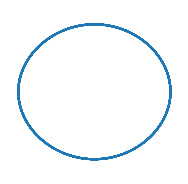

In [7]:
plt.figure(figsize=(3,3))
plt.plot(z_sim[:,0], z_sim[:,1], linewidth=2)
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

In [8]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.015891
Decoder relative SINDy error: 0.015747
SINDy reltive error, z: 0.008373
